This notebook shows all inputs needed for the calculation of the EBL,
and how to calculate the outputs.

Inputs for the EBL caused by the stellar population:
- Stellar synthetic spectra
- Stellar formation rate
- Metallicity evolution
- Dust absorption model
- Dust reemission template (and possible parameters associated with the template)

Inputs for the EBL caused by the intrahalo light (Stars expelled from their galaxies):
- A_ihl
- alpha

# Imports

In [2]:
# Check that the working directory is correct for the paths
import os

if os.path.basename(os.getcwd()) == 'scripts' or os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir("..")

# If the directory for outputs is not present, create it.
if not os.path.exists("outputs/"):
    os.makedirs("outputs/")

In [4]:
import yaml
import psutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c
from scipy.interpolate import UnivariateSpline, RegularGridInterpolator

from niebla import ebl_model, measurements

# If we want to compare our results to previous calculations of the EBL, we load ebltable
# from https://github.com/me-manu/ebltable
from ebltable.ebl_from_model import EBL

data_path /home/porrassa/Desktop/EBL_ModelCode/niebla/src/niebla/data/
Module hmf not loaded


### Some matplotlib values that I like for my graphs
Please feel free to change these (but I think they are cool)

In [5]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.labelsize'] = 20
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=17)
plt.rc('xtick', top=True, direction='in')
plt.rc('ytick', right=True, direction='in')
plt.rc('xtick.major', size=7, width=1.5, top=True)
plt.rc('ytick.major', size=7, width=1.5, right=True)
plt.rc('xtick.minor', size=4, width=1)
plt.rc('ytick.minor', size=4, width=1)

In [6]:
# Some arrays to distinguish different models in the next plots
models = ['solid', 'dashed', 'dotted', 'dashdot']
colors = ['b', 'r', 'g', 'orange', 'grey', 'purple', 'k', 'cyan', 'brown']

linstyles_ssp = ['solid', '--', 'dotted', '-.']

markers = ['.', 'x', '+', '*', '^', '>', '<']
color_ssp = ['b', 'orange', 'k', 'r', 'green', 'grey', 'limegreen', 'purple', 'brown']

# Configuration file reading and data input/output

In [7]:
# Directory where we have the yaml file that has the inputs for our model
# If you want to save figures, it's very useful to use this directory to save them
# (i.e. plt.savefig(input_file_dir + NAME_FIG.pdf, bbox_inches='tight'))

input_file_dir = ('notebooks/')

In [9]:
# Configuration file reading and data input/output
def read_config_file(ConfigFile):
    with open(ConfigFile, 'r') as stream:
        try:
            parsed_yaml = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return parsed_yaml

# We initialize the class with the input file
config_data = read_config_file(input_file_dir + 'input_example.yml')
ebl_class = ebl_model.EBL_model.input_yaml_data_into_class(config_data, log_prints=True)

2025-08-27 15:49:31 - INFO - 0.02s: Initialize class: end


{'z_min': 0.0, 'z_max': 10.0, 'z_steps': 100}


## Inputs in the config file
List of inputs in the config file and its definitions.

First, general ones that need to appear for the correct funtioning of the code:

**COSMOLOGY CONSTANTS (flat LCDM assumed)**
```
cosmology_params:
  cosmo: [0.7, 0.3, 0.7] # [h_0, omega_matter, omega_L]
  omegaBar: 0.0453 # omega baryons of our model (this example = 0.0222/0.7**2.)
```
> These four parameters $h_0$, $\omega_{matter}$, $\omega_{\lambda}$ and $\omega_{baryons}$ are input in the class `FlatLambdaCDM` of `astropy.cosmology`. They can be changed, but beware because if you want to compare them to data: in order to calculate data, a cosmological model is assumed (for most observations). Altering the cosmological model might make it impossible (or wrong) to compare the output model with observational data.

**WAVELENGTH ARRAY FOR EBL [microns]**
```
wavelength_array:
  lfsteps: 700
  lmax: 1e5
  lmin: 1e-2
```
> Wavelength array where to calculate the EBL intensities and emissivities. They have to be given in microns. This example covers both the optical and infrared parts of the electromagnetic spectrum.

**REDSHIFT ARRAY FOR EBL**
```
redshift_array:
  zmin: 0.
  zmax: 10.0
  zsteps: 100
```
> This is the redshift array where the emissivities and EBL will be avaible as outputs. This does not denote the integration limit at high redshift. That one is given by the next parameter:
```
z_intmax: 40.0
```
> This is $z_{max}$ in Eq.(B1) in the paper based on this code, its physical meaning is the maximum reshift ar which the . I reccomend to not change this value.

**NUMBER OF INTEGRATION STEPS**
```
t_intsteps: 201
```
> Same as before, this number is appropiate for sampling the integral kernels.

**PRINT THE LOGS OF THE PROGRAM**

```
log_prints: True
```
> Finally, the possibility of having the program spit all the verbose or silently run. Change this parameter at any point in your program to decide whether you want detailed information about the processes happening or you would prefer the calculations to be silent.

2025-08-27 15:52:44 - INFO - 1.45s: SSP parameters: Stripped Goetberg19


{'cosmology_params': {'cosmo': [0.7, 0.3, 0.7], 'omegaBar': 0.0453}, 'wavelength_array': {'wv_min': '1e-2', 'wv_max': '1e5', 'wv_steps': 700}, 'redshift_array': {'z_min': 0.0, 'z_max': 10.0, 'z_steps': 100}, 'z_intmax': 40.0, 't_intsteps': 201, 'log_prints': True, 'axion_params': {'axion_mass': 1, 'axion_gamma': '5e-10'}, 'ihl_params': {'A_ihl': -3.23, 'alpha': 1}, 'ssp_models': {'stripped_Goetberg19': {'dust_abs_models': ['finke2022'], 'dust_abs_params': {'fesc_steps_fn22': [0.19026841739819628, 0.21769647479187074, 0.24664564616751203, 0.4405596977469474, 0.702267829157408], 'params_fermi18': [1.52, 0.35, 4.12, 5.89]}, 'dust_reem': False, 'metall_formula': 'metall_tanikawa22', 'metall_params': [-1.363077660454558e-06, 0.1709136894779165, 1.0750514513578506, 0.02], 'name': 'Stripped Goetberg19', 'sfr_formula': 'sfr_madau14', 'sfr_params': [0.015915657766652082, 2.303543288627401, 3.287937285946092, 6.633075702961276], 'ssp': {'ssp_type': 'generic', 'ignore_rows': 0, 'total_stellar_mas

KeyError: 'path_ssp'

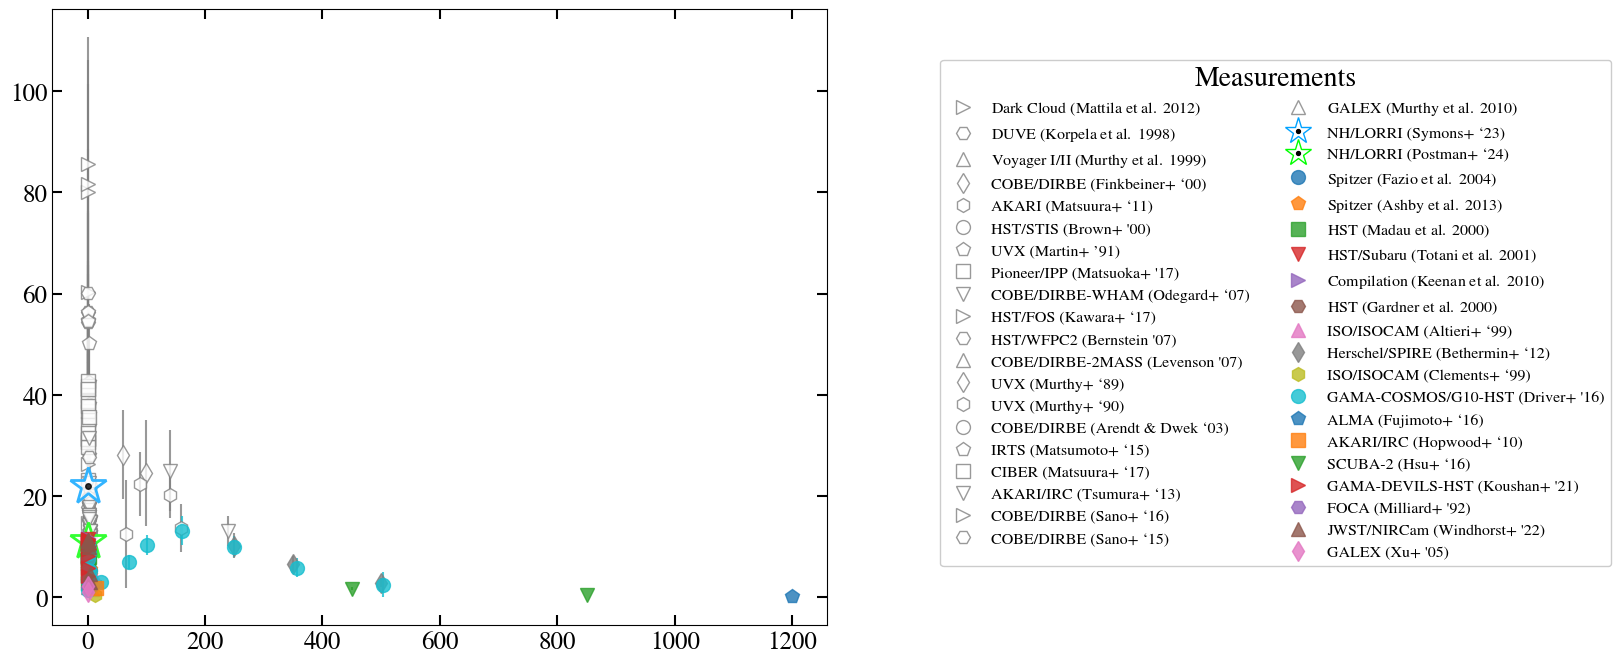

In [12]:
fig_cob, ax_cob = plt.subplots(figsize=(10, 8))

measurements.ebl(
    lambda_min_total=0.08, fig=fig_cob, ax=ax_cob,
    colors_UL=['grey'], plot_UL=True, plot_IGL=True,
    show_legend=True)

print(config_data)

waves_ebl = np.logspace(-1, 3, num=500)
freq_array_ebl = np.log10(3e8 / (waves_ebl * 1e-6))

for nkey, key in enumerate(config_data['ssp_models']):
    print()
    print('SSP model: ', config_data['ssp_models'][key]['name'])

    ebl_class.ebl_ssp_calculation(config_data['ssp_models'][key])

    ax_cob.plot(waves_ebl, ebl_class.ebl_ssp_spline(
        waves_ebl, 0.),
                linestyle='-', color=colors[nkey % len(colors)],
                lw=3,
                # markersize=16, marker=markers[nkey]
                )

# We introduce the Finke22 and CUBA splines from ebltable
ebl = {}
for m in EBL.get_models():
    ebl[m] = EBL.readmodel(m)
nuInu = {}
for m, e in ebl.items():
    nuInu[m] = e.ebl_array(np.array([0.]), waves_ebl)
spline_finke = UnivariateSpline(waves_ebl, nuInu['finke2022'], s=0, k=1)
spline_cuba = UnivariateSpline(waves_ebl, nuInu['cuba'], s=0, k=1)
ax_cob.plot(waves_ebl, spline_finke(waves_ebl),
            c='orange', label='Finke22 model A')
ax_cob.plot(waves_ebl, spline_cuba(waves_ebl),
            c='fuchsia', label='CUBA')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'$\nu I_{\nu}$ (nW / m$^2$ sr)')

legend22 = plt.legend()
legend33 = ax_cob.legend([plt.Line2D([], [], linewidth=2, linestyle='-',
                                     color=colors[i])
                          for i in range(len(config_data['ssp_models']))],
                         [config_data['ssp_models'][key]['name']
                          for key in config_data['ssp_models']],
                         title=r'SSP models',  # bbox_to_anchor=(1.04, 0.1),
                         loc=3
                         )

ax_cob.add_artist(legend22)
ax_cob.add_artist(legend33)


import_cb_data(plot_measurs=True, ax1=ax_cob, lambda_max_total=1000)

plt.xlim([.1, 1000])
plt.ylim(1e-2, 100)

# OUTPUTS OF THE CODE: EMISSIVITIES, EBL INTENSITIES

## FIGURE: EMISSIVITIES FOR DIFFERENT MODELS

Here we show how to calculate the emissivities from the inputs we have previously shown. We have data points that depend on wavelength and redshift, so we create an spline that takes both of these parameters.


Snippet of the necessary lines of code to calculate the emissivities:

```
ebl_class = EBL_model.input_yaml_data_into_class(config_data, log_prints=True)
ebl_class.emiss_ssp_calculation(config_data['ssp_models'][NAME_OF_MODEL])
```

And can be used afterwards with an spline:

```
ebl_class.emiss_ssp_spline(freq_array_ebl, zz)
```

2024-11-18 14:56:03 - INFO - 1.97s: SSP parameters: Our model
/home/saraporras/PycharmProjects/EBL_calculation/ebl_codes/dust_absorption_models.py:265: RuntimeWarning: invalid value encountered in log10
  return np.log10(yy)
2024-11-18 14:56:03 - INFO - 0.09s: SSP emissivity: set dust absorption
2024-11-18 14:56:03 - INFO - 0.00s: Dust reem: enter



SSP model:  Our model
   -> Default parameters for lambda_steps_fn22 chosen:  [0.15, 0.167, 0.218, 0.422, 2.0]


2024-11-18 14:56:04 - INFO - 0.68s: Dust reem: mean metall calc
2024-11-18 14:56:09 - INFO - 5.41s: Dust reem: lumin_abs calc
2024-11-18 14:56:09 - INFO - 0.13s: Dust reem: integration of Lssp
2024-11-18 14:56:09 - INFO - 0.00s: Dust reem: reading of template file
2024-11-18 14:56:09 - INFO - 0.01s: Dust reem: calculation of luminosities
2024-11-18 14:56:09 - INFO - 0.00s: Dust reem: integration of Ltir
2024-11-18 14:56:09 - INFO - 0.00s: Dust reem: creation of big array
2024-11-18 14:56:09 - INFO - 0.00s: Dust reem: dust spline creation
2024-11-18 14:56:15 - INFO - 5.50s: Dust reem: sum to kernel_emiss
2024-11-18 14:56:15 - INFO - 0.56s: SSP emissivity: calculate ssp kernel
2024-11-18 14:56:16 - INFO - 0.22s: SSP emissivity: integrate emissivity
2024-11-18 14:56:16 - INFO - 0.00s: SSP emissivity: end


TypeError: emiss_ssp_spline() missing 1 required positional argument: 'zz_array'

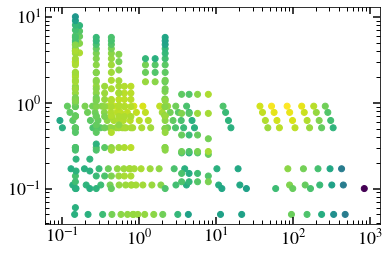

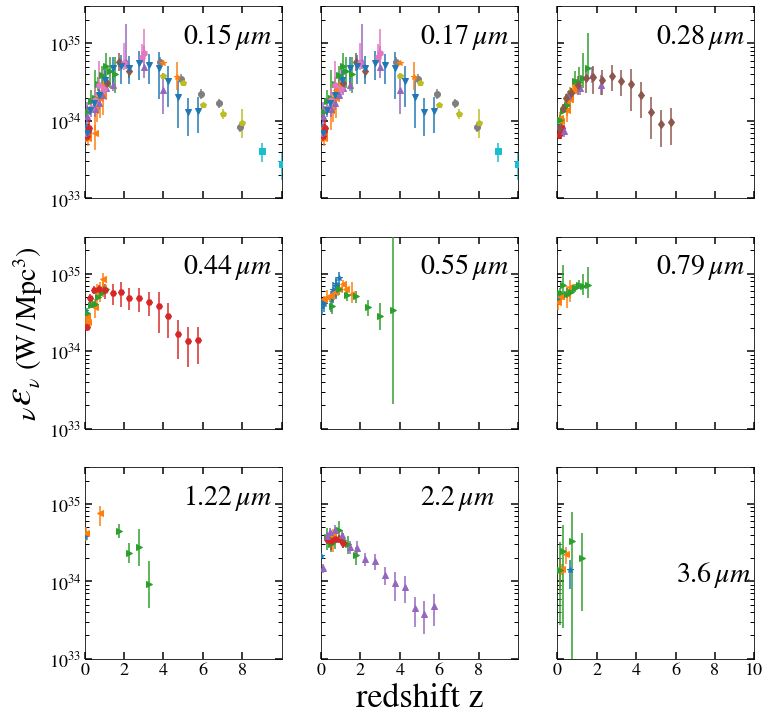

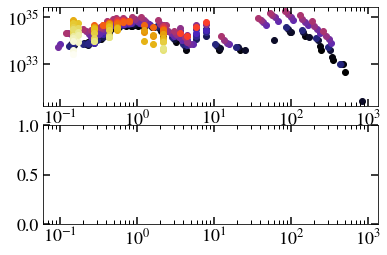

In [9]:
plt.figure()


waves_ebl = np.logspace(-1, 3, num=500)
freq_array_ebl = np.log10(3e8 / (waves_ebl * 1e-6))

emiss_data = emissivity_data(z_min=None, z_max=None,
                    lambda_min=0., lambda_max=3e3,
                    take1ref=None, plot_fig=False)
plt.scatter(x=emiss_data['lambda'], y=emiss_data['z'],
            c=np.log10(emiss_data['eje']),
            cmap='viridis')

plt.xscale('log')
plt.yscale('log')

fig_emiss_lambda, (ax_emiss_lambda0, ax_emiss_lambda1) = plt.subplots(2, 1)
plt.subplot(211)
for nz, zz in enumerate(np.unique(emiss_data['z'])):
    ax_emiss_lambda0.scatter(x=emiss_data['lambda'][emiss_data['z'] == zz],
                y=emiss_data['eje'][emiss_data['z'] == zz],
            color=plt.cm.CMRmap(nz / float(len(np.unique(emiss_data['z'])))),
                )

ax_emiss_lambda0.set_xscale('log')
ax_emiss_lambda0.set_yscale('log')

plt.subplot(212, sharex=ax_emiss_lambda0)

ax_emiss_lambda1.set_xscale('log')


fig_emiss_z, axes_emiss_z = plt.subplots(3, 3, figsize=(12, 12))

z_array = np.linspace(1e-9, 10., num=100)

for n_lambda, ll in enumerate([0.15, 0.17, 0.28,
                               0.44, 0.55, 0.79,
                               1.22, 2.2, 3.6]):
    plt.subplot(3, 3, n_lambda + 1)
    emissivity_data(z_min=None, z_max=None,
                    lambda_min=ll - 0.05, lambda_max=ll + 0.05,
                    take1ref=None, plot_fig=True)

    if n_lambda != 8:
        plt.annotate(r'%r$\,\mu m$' % ll, xy=(5, 1e35), fontsize=28)

    plt.xlim(min(z_array), max(z_array))
    plt.ylim(1e33, 3e35)

    plt.yscale('log')

handles_emiss, labels_emiss = [], []

plt.subplot(3, 3, 8)
plt.xlabel(r'redshift z', fontsize=34)

plt.subplot(3, 3, 4)
plt.ylabel(r'$_{\nu} \varepsilon_{_{\nu} \,\,(\mathrm{W\, / \, Mpc}^3)}$',
           fontsize=40)

plt.subplot(3, 3, 9)
plt.annotate(r'3.6$\,\mu m$', xy=(6, 1e34), fontsize=28)

ax = [plt.subplot(3, 3, i) for i in [2, 3, 5, 6, 8, 9]]
for a in ax:
    a.set_yticklabels([])

ax = [plt.subplot(3, 3, i + 1) for i in range(6)]
for a in ax:
    a.set_xticklabels([])

ax = [plt.subplot(3, 3, i + 1) for i in range(6, 8)]
for a in ax:
    a.set_xticks([0, 2, 4, 6, 8])

ax = [plt.subplot(3, 3, i) for i in range(1, 7)]
for a in ax:
    a.set_xticks([0, 2, 4, 6, 8, 10])

a = plt.subplot(3, 3, 9)
a.set_xticks([0, 2, 4, 6, 8, 10])

# SSPs component calculation (all models listed in the input file)
for nkey, key in enumerate(config_data['ssp_models']):
    print()
    print('SSP model: ', config_data['ssp_models'][key]['name'])

    ebl_class.emiss_ssp_calculation(config_data['ssp_models'][key])

    plt.figure(fig_emiss_lambda)
    for nz, zz in enumerate(np.unique(emiss_data['z'])):
        plt.subplot(211)
        ax_emiss_lambda0.plot(waves_ebl, 10 ** ebl_class.emiss_ssp_spline(
                     (freq_array_ebl, zz)) * 10**freq_array_ebl * 1e-7,
                    color=plt.cm.CMRmap(
                        nz / float(len(np.unique(emiss_data['z'])))),
                    zorder=0, alpha=0.75)
        freq_arr_emiss = (3e8*1e6/emiss_data['lambda'][emiss_data['z'] == zz])

        plt.subplot(212)
        plt.plot(
            emiss_data['lambda'][emiss_data['z'] == zz],
            ((10 ** ebl_class.emiss_ssp_spline(
                     (np.log10(freq_arr_emiss), zz))
               * freq_arr_emiss * 1e-7
               - emiss_data['eje'][emiss_data['z'] == zz])
              / ((emiss_data['eje_n'][emiss_data['z'] == zz]
                  + emiss_data['eje_p'][emiss_data['z'] == zz]) / 2.)),
                    color=plt.cm.CMRmap(
                        nz / float(len(np.unique(emiss_data['z'])))),
            ls='', marker='.'
                    )

    plt.figure(fig_emiss_z)
    for n_lambda, ll in enumerate([0.15, 0.17, 0.28,
                                   0.44, 0.55, 0.79,
                                   1.22, 2.2, 3.6]):
        plt.subplot(3, 3, n_lambda + 1)

        plt.plot(z_array,
                 (c.value / (ll * 1e-6))
                 * 10 ** ebl_class.emiss_ssp_spline(
                     (np.log10(c.value / ll * 1e6) * np.ones(
                         len(z_array)),
                     z_array))
                 * 1e-7,
                 linestyle='-', marker=markers[nkey],
                 color=colors[nkey % len(colors)], lw=2)

    labels_emiss.append(
        config_data['ssp_models'][key]['name'])
    handles_emiss.append(plt.Line2D([], [], linewidth=2,
                                    linestyle='-',
                                    color=colors[nkey % len(colors)]))

## FIGURE: CB FOR DIFFERENT MODELS

Here we show how to calculate the EBL from the inputs we have previously shown. The only requisite to calculate the EBL is to have initialized the EBL_model class with a yaml file.

Above this cell we have displayed various commands to show the inputs of the code, but none of these calculations are necessary to calculate the EBL. Moreover, calculating the EBL will initialize the SSP spectra and calculate the emissivities, so using only this command the other values will be calculated and saved in memory. This is preferred since it will save time and computing power.

Snippet of the necessary lines of code to calculate the EBL:
```
ebl_class = EBL_model.input_yaml_data_into_class(config_data, log_prints=True)
ebl_class.ebl_ssp_calculation(config_data['ssp_models'][NAME_OF_MODEL])
```

And can be used afterwards with an spline:

```
ebl_class.ebl_ssp_spline(freq_array_ebl, zz)
```

## Writing the EBL models to txt files
Creates a file containing the values for wavelength, redshift and EBL values, 
of dimensions (n+1) x (m+1). This file is compatible with the package ebltable, serving as an input to calculate optical depths.

The zeroth column contains the n wavelength values in mu meters.

The first row contains the m redshift values.

The remaining values (n x m) are the EBL photon density values in nW / m$^2$ sr.

The entry [0,0] is empty.

In [ ]:
ebl_class.logging_prints = False

for nkey, key in enumerate(config_data['ssp_models']):
    print()
    print('SSP model: ', config_data['ssp_models'][key]['name'])

    ebl_class.ebl_ssp_calculation(config_data['ssp_models'][key])
    ebl_class.write_ebl_to_ascii(output_path=input_file_dir, name=key)